In [1]:
# Imports necessary for the project
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

Data Collection and Cleaning

In [10]:
# Loading the downloaded data
df = pd.read_csv("/Users/shivasaivummaji/Desktop/CS:DS/Semesters/Spring 2025/Labor Economics/Project/cps_00006.csv.gz")
df.head()

,YEAR,SERIAL,MONTH,HWTFINL,CPSID,ASECFLAG,ASECWTH,PERNUM,WTFINL,CPSIDP,...,SEX,RACE,EMPSTAT,UHRSWORKT,EDUC,EARNWT,INCWAGE,HOURWAGE,PAIDHOUR,EARNWEEK
0,2020,1,3,NaN,20190302844900,1.0,1560.3756,1,NaN,20190302844901,...,2,100,10,40,73,0.00,52500.0,999.99,0,9999.99
1,2020,1,3,NaN,20190302844900,1.0,1560.3756,2,NaN,20190302844902,...,1,100,36,999,73,0.00,56000.0,999.99,0,9999.99
2,2020,2,3,NaN,20181202843500,1.0,986.5948,1,NaN,20181202843501,...,1,100,10,48,73,4871.85,34000.0,999.99,1,654.00
3,2020,2,3,NaN,20181202843500,1.0,986.5948,2,NaN,20181202843502,...,2,100,36,999,50,3843.59,0.0,999.99,0,9999.99
4,2020,3,3,NaN,20190202831700,1.0,1519.0704,1,NaN,20190202831701,...,2,100,10,44,73,0.00,40000.0,999.99,0,9999.99


In [11]:
# Keep workers who are in the working-age between 18 to 65.
workers = df[df["AGE"].between(18, 65)]

# Keep only employed individuals
workers = workers.query("EMPSTAT == 10")

# Replace default values with np.nan
workers.loc[:, 'HOURWAGE'] = workers['HOURWAGE'].replace(999.99, np.nan)
workers.loc[:, 'UHRSWORKT'] = workers['UHRSWORKT'].replace([997, 998, 999], np.nan)
workers.loc[:, 'INCWAGE'] = workers['INCWAGE'].replace(9999999, np.nan)

# Construct hourly wages for the workers
workers["hourly_wage"] = np.where(
    (workers["PAIDHOUR"] == 1) & (~workers["HOURWAGE"].isna()),
    workers["HOURWAGE"],
    workers["INCWAGE"] / (workers["UHRSWORKT"] * 52)
)

# Drop invalid/NaN hourly wages
workers = workers.dropna(subset=["hourly_wage"])

# Keep only the columns mentioned in my initial document:
keep_cols = [
    'SEX', 'RACE', 'AGE', 'EDUC', 'UHRSWORKT', 'hourly_wage', 'INCWAGE'
]
workers = workers[keep_cols]

workers


/var/folders/zw/1p1g2scn1llcnl481zdq41wm0000gn/T/ipykernel_49866/2974635011.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[40. 48. 44. ... 40. 35. nan]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  workers.loc[:, 'UHRSWORKT'] = workers['UHRSWORKT'].replace([997, 998, 999], np.nan)


,SEX,RACE,AGE,EDUC,UHRSWORKT,hourly_wage,INCWAGE
0,2,100,63,73,40.0,25.240385,52500.0
2,1,100,64,73,48.0,13.621795,34000.0
4,2,100,54,73,44.0,17.482517,40000.0
6,1,100,37,73,21.0,7.714286,8424.0
14,2,100,35,91,40.0,20.192308,42000.0
...,...,...,...,...,...,...,...
4756385,2,200,36,111,40.0,12.019231,25000.0
4756386,1,200,27,73,40.0,14.423077,30000.0
4756388,2,651,35,81,8.0,60.096154,25000.0
4756392,1,100,46,92,40.0,38.461538,80000.0


In [12]:
# Converting categorical variables (SEX, RACE, EDUC) to labels

workers['EDUC'] = pd.to_numeric(workers['EDUC'], errors='coerce')

def map_educ_group(educ):
    if educ in [31, 32]:
        return "Less than High School"
    elif educ in [40, 41, 73]:
        return "High School Graduate"
    elif educ == 81: 
        return "Some College, No Degree"
    elif educ in [90, 91, 92]: 
        return "Associate Degree"
    elif educ in [110, 111]: 
        return "Bachelor’s Degree"
    elif educ == 123: 
        return "Master’s Degree"
    elif educ in [124, 125]:
        return "Advanced Degree (Professional/Doctorate)"
    else:
        return "Other"

workers['EDUC_GROUP'] = workers['EDUC'].apply(map_educ_group)

map_sex = {1: 'Male', 2: 'Female'}
workers['SEX'] = workers['SEX'].map(map_sex)

map_race = {
    100: 'White',
    200: 'Black',
    300: 'American Indian',
    651: 'Asian',
    652: 'Hawaiian/Pacific Islander',
    801: 'Other',
    802: 'Two or more races'
}
workers['RACE'] = workers['RACE'].map(map_race)

workers

,SEX,RACE,AGE,EDUC,UHRSWORKT,hourly_wage,INCWAGE,EDUC_GROUP
0,Female,White,63,73,40.0,25.240385,52500.0,High School Graduate
2,Male,White,64,73,48.0,13.621795,34000.0,High School Graduate
4,Female,White,54,73,44.0,17.482517,40000.0,High School Graduate
6,Male,White,37,73,21.0,7.714286,8424.0,High School Graduate
14,Female,White,35,91,40.0,20.192308,42000.0,Associate Degree
...,...,...,...,...,...,...,...,...
4756385,Female,Black,36,111,40.0,12.019231,25000.0,Bachelor’s Degree
4756386,Male,Black,27,73,40.0,14.423077,30000.0,High School Graduate
4756388,Female,Asian,35,81,8.0,60.096154,25000.0,"Some College, No Degree"
4756392,Male,White,46,92,40.0,38.461538,80000.0,Associate Degree


In [13]:
workers.to_csv("cleaned_data.csv", index=False)

Exploratory Analysis

In [14]:
# Statistics for continuous variables
print(workers.describe())

                 AGE           EDUC      UHRSWORKT    hourly_wage  \
count  299219.000000  299219.000000  299219.000000  299219.000000   
mean       41.330855      91.822708      39.931599      30.224410   
std        12.461130      23.149237      10.560664      46.104601   
min        18.000000       2.000000       1.000000       0.000000   
25%        31.000000      73.000000      40.000000      13.000000   
50%        41.000000      91.000000      40.000000      22.157191   
75%        51.000000     111.000000      40.000000      36.057692   
max        65.000000     125.000000     198.000000    9615.384615   

            INCWAGE  
count  2.992190e+05  
mean   6.321969e+04  
std    8.034638e+04  
min    0.000000e+00  
25%    2.500000e+04  
50%    4.700000e+04  
75%    7.700000e+04  
max    2.099999e+06  


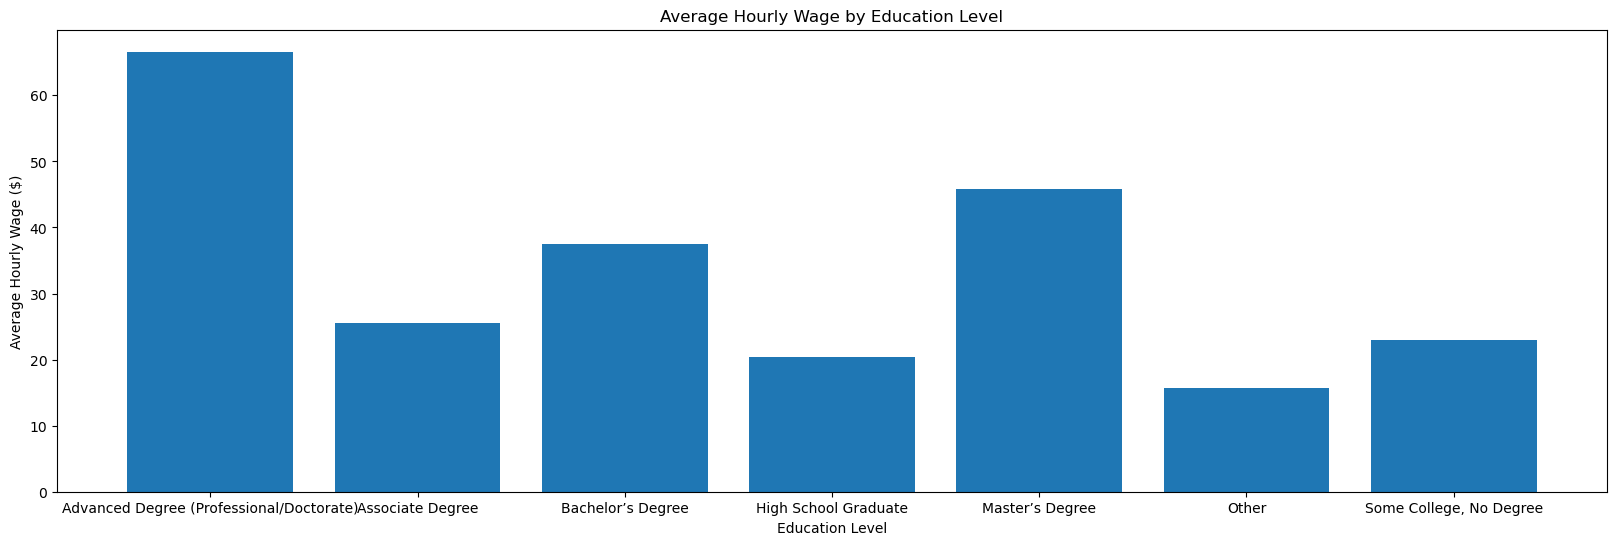

In [18]:
# Wage distribution by education
edu_wage = workers.groupby('EDUC_GROUP')['hourly_wage'].mean()

plt.figure(figsize=(20,6))
plt.bar(edu_wage.index, edu_wage.values)
plt.title('Average Hourly Wage by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Average Hourly Wage ($)')
plt.savefig("wage_by_education.png")
plt.show()

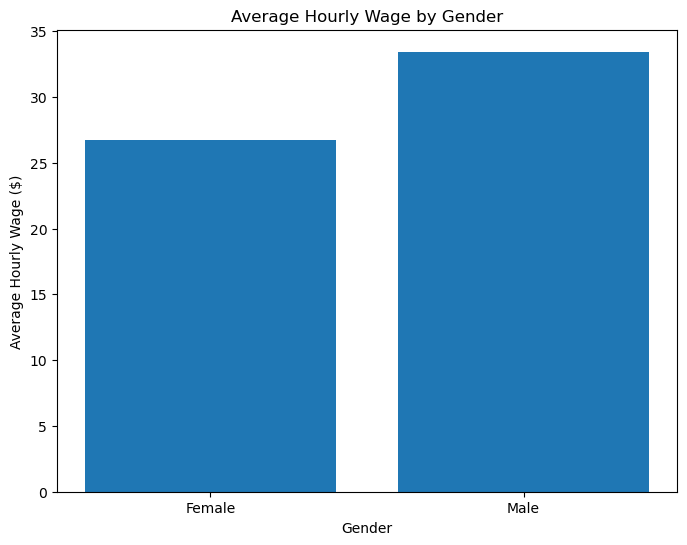

In [19]:
# Wage Distribution by Gender
gender_wage = workers.groupby('SEX')['hourly_wage'].mean()

plt.figure(figsize=(8,6))
plt.bar(gender_wage.index, gender_wage.values)
plt.title('Average Hourly Wage by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Hourly Wage ($)')
plt.savefig("wage_by_gender.png")
plt.show()



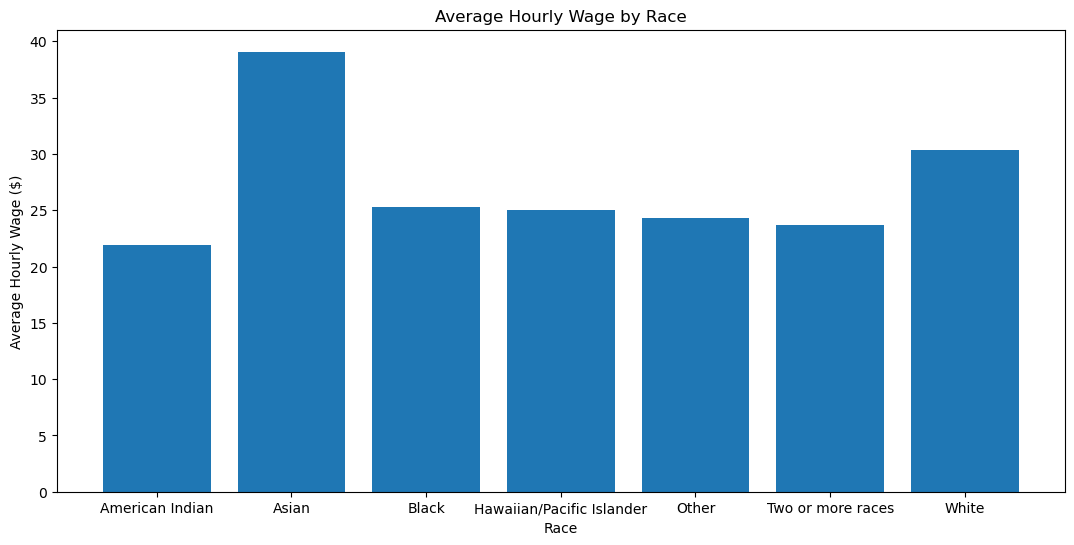

In [20]:
# Wage Distribution by Race
race_wage = workers.groupby('RACE')['hourly_wage'].mean()

plt.figure(figsize=(13,6))
plt.bar(race_wage.index, race_wage.values)
plt.title('Average Hourly Wage by Race')
plt.xlabel('Race')
plt.ylabel('Average Hourly Wage ($)')
plt.savefig("wage_by_race.png")
plt.show()



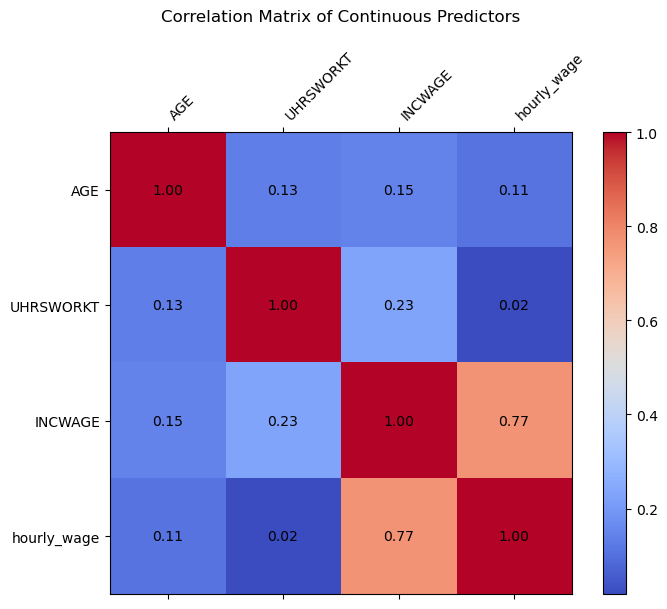

In [22]:
continuous_vars = ['AGE', 'UHRSWORKT', 'INCWAGE', 'hourly_wage']
corr = workers[continuous_vars].corr()

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(corr, cmap='coolwarm')
fig.colorbar(cax)

# Set axis ticks
ax.set_xticks(np.arange(len(continuous_vars)))
ax.set_yticks(np.arange(len(continuous_vars)))
ax.set_xticklabels(continuous_vars, rotation=45, ha='left')
ax.set_yticklabels(continuous_vars)

# Annotate each cell
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f'{val:.2f}', va='center', ha='center', color='black')

plt.title('Correlation Matrix of Continuous Predictors', pad=20)
plt.savefig("correlation_matrix.png")
plt.show()
